In [1]:
#include("MAB_module.jl")
include("environment.jl")
include("algorithm_base.jl")
include("eps_greedy.jl")
include("rs.jl")
#include("lsx.jl")
#include("meta-bandit.jl")
include("ucb1tuned.jl")

update! (generic function with 3 methods)

In [2]:
using Plots
using Statistics
#using Base.Threads

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
mutable struct LSX <: Algorithm
    env::Environment
    actionValues::Vector{Float64}
    counts::Vector{Int}             #numbers of selection of each arm.
    w::Vector{Float64}
    l::Vector{Float64}
    r::Float64
    gamma::Float64
    alpha::Float64
    model::String
    #constructor
    function LSX(;env::Environment, alpha::Float64, model="", gamma=1.0)
        if model == "opt"
            r = opt_r(env.arm_pros)
        else
            r = 0.5
        end

        return new( env,
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    r,
                    gamma,
                    alpha,
                    model)
    end
end

In [4]:
function init!(algo::LSX)
    algo.actionValues = zeros(algo.env.arm_num)
    algo.counts = zeros(algo.env.arm_num)
    if algo.model == "opt"
        algo.r = opt_r(algo.env.arm_pros)
    else
        algo.r = 0.5
    end

    for i=1:algo.env.arm_num
        algo.w[i] = eps(0.0)
        algo.l[i] = eps(0.0)
    end
end

#epsilon greedy
function select_arm(algo::LSX)
    #return index of maximum value in the action values.
    return greedy(algo)
end

#chose arm and update each parameter.
function update!(algo::LSX)
    _, a_mt = findmax(algo.counts)
    _, a_lt = findmin(algo.counts)
    b_ebar = (algo.l[a_mt] * algo.l[a_lt]) / (algo.l[a_mt] + algo.l[a_lt])
    b_e = (algo.w[a_mt] * algo.w[a_lt]) / (algo.w[a_mt] + algo.w[a_lt])
    n_k = b_ebar + b_e

    for i=1:algo.env.arm_num
        algo.actionValues[i] =
            (algo.w[i] + 2*algo.r*n_k - b_e) / (algo.w[i] + algo.l[i] + n_k)
    end

    selected = select_arm(algo)
    reward = get_reward(algo.env.arm_pros, selected)

    for i=1:algo.env.arm_num
        algo.w[i] = algo.gamma * algo.w[i]
        algo.l[i] = algo.gamma * algo.l[i]
    end

    if reward == 1
        algo.w[selected] += 1
    else
        algo.l[selected] += 1
    end

    #update this experiment's current state.
    algo.counts[selected] += 1

    if algo.model != "opt"
        algo.r = algo.r + algo.alpha * (algo.w[selected]/algo.counts[selected] - algo.r)
    end
    #calc regret.
    regret = algo.env.max_pro - algo.env.arm_pros[selected]

    return selected, regret, reward

end

function opt_r(arms)
    sorted_pro = sort(arms, rev=true)
    r = (sorted_pro[1] + sorted_pro[2]) / 2
    return r
end

opt_r (generic function with 1 method)

In [19]:
function simulation(;sim_num::Int, steps::Int, update_per::Int, arm_num=4, dynamic=false)
    #argument checking.
    if dynamic && update_per <= steps && steps % update_per != 0
        println("update number error.")
        return
    end

    update_num = div(steps, update_per)#convert(Int64, steps/update_per)
    env = Environment(arm_num)

    algo_dict = Dict()
    # for gamma in [0.8]
    #     alpha = 1/(10^3)
    #     algo_dict["MYRS gamma=$gamma"] = MYRS(env, 1., gamma, alpha)
    # end
    # for gamma in [0.9, 0.8]
    #     algo_dict["MYRS merge gamma=$gamma"] = MYRS(env, 1., gamma, 0.001, "merge")
    # end

    #algo_dict["RS"] = RS(env)
    #algo_dict["UCB1"] = UCB1(env, false)
    #algo_dict["LSX"] = LSX(env)
    for i=4:7
        alpha = 1/(10^i)
        algo_dict["LSX gamma alpha=$alpha"] = LSX(env=env,
                                            alpha=alpha, gamma=0.999)
    end
    algo_dict["LSX opt"] = LSX(env=env,
                                        alpha=0.1,
                                        model="opt")
    
    algo_dict["LSX opt gamma"] = LSX(env=env,
                                        alpha=0.1,
                                        model="opt",
                                        gamma=0.999)



    #rlist = zeros(steps)
    #rsum = 0.
    regret_means, win_means, action_vals = Vector{}(), Vector{}(), Vector{}()
    for algorithm in values(algo_dict)
        regrets, wins = zeros(sim_num, steps), zeros(sim_num, steps)
        #action_val = Vector{}()
        for sim in 1:sim_num
            ds = rand(update_num,arm_num)
            update_env!(env, ds[1, :])
            init!(algorithm)
            regret = 0.
            for step in 1:steps-1
                selected, rgt, reward = update!(algorithm)
                #selected, rgt, _ = simple_update!(algorithm)        #for RS algorithm.
                #selected, rgt, _, phs[step] = update!(algorithm)   #for debug.

                #save each parameter.
                regret += rgt
                regrets[sim, step] = regret
                #push!(action_val, algorithm.actionValues[:]')

                if selected == env.correct_arm
                    wins[sim, step] = 1
                end
                # if typeof(algorithm) == MYRS
                #     rsum += (reward - algorithm.r)
                #     rlist[step] = rsum#algorithm.actionValues[env.correct_arm]
                # end

                if dynamic
                    if (step % update_per) == 0
                        #@show env.arm_pros[env.correct_arm]
                        ds_idx = div(step, update_per)
                        update_env!(env, ds[ds_idx+1, :])
                        #println("<----------updated------------->")
                        if typeof(algorithm) == RS
                            update_r!(algorithm)
                        elseif typeof(algorithm) == LSX
                            algorithm.r = opt_r(algorithm.env.arm_pros)
                        end
                    end
                end

            end
             if sim % 10 == 0
                print("$((sim/sim_num)*100) %")
            end
        end
        println("DONE.")
        push!(regret_means, [mean(regrets[:, i]) for i=1:steps])
        push!(win_means, [mean(wins[:, i]) for i=1:steps])
        #push!(action_vals, vcat(action_val...))
    end

    println("DONE.")
    #@show ds
    #@show action_vals

    graph_data = hcat(win_means...)
    time = Vector{Int}(1:steps)
    #xscale=:log

    #graph_data2 = hcat(action_vals...)
    graph_data2 = hcat(regret_means...)
    #graph_data2 = rlist

    return graph_data, graph_data2, algo_dict
end

simulation (generic function with 1 method)

In [22]:
g1, g2, algo_dict = simulation(sim_num=1000,
                            steps=100000,
                            update_per=10000,
                            arm_num=20,
                            dynamic=true)

1.0 %2.0 %3.0 %4.0 %5.0 %6.0 %7.000000000000001 %8.0 %9.0 %10.0 %11.0 %12.0 %13.0 %14.000000000000002 %15.0 %16.0 %17.0 %18.0 %19.0 %20.0 %21.0 %22.0 %23.0 %24.0 %25.0 %26.0 %27.0 %28.000000000000004 %28.999999999999996 %30.0 %31.0 %32.0 %33.0 %34.0 %35.0 %36.0 %37.0 %38.0 %39.0 %40.0 %41.0 %42.0 %43.0 %44.0 %45.0 %46.0 %47.0 %48.0 %49.0 %50.0 %51.0 %52.0 %53.0 %54.0 %55.00000000000001 %56.00000000000001 %56.99999999999999 %57.99999999999999 %59.0 %60.0 %61.0 %62.0 %63.0 %64.0 %65.0 %66.0 %67.0 %68.0 %69.0 %70.0 %71.0 %72.0 %73.0 %74.0 %75.0 %76.0 %77.0 %78.0 %79.0 %80.0 %81.0 %82.0 %83.0 %84.0 %85.0 %86.0 %87.0 %88.0 %89.0 %90.0 %91.0 %92.0 %93.0 %94.0 %95.0 %96.0 %97.0 %98.0 %99.0 %100.0 %DONE.
1.0 %2.0 %3.0 %4.0 %5.0 %6.0 %7.000000000000001 %8.0 %9.0 %10.0 %11.0 %12.0 %13.0 %14.000000000000002 %15.0 %16.0 %17.0 %18.0 %19.0 %20.0 %21.0 %22.0 %23.0 %24.0 %25.0 %26.0 %27.0 %28.000000000000004 %28.999999999999996 %30.0 %31.0 %32.0 %33.0 %34.0 %35.0 %36.0 %37.0 %38.0 %39.0 %40.0 %41.0 %4

([0.05 0.063 … 0.057 0.053; 0.07 0.09 … 0.077 0.079; … ; 0.599 0.757 … 0.75 0.718; 0.0 0.0 … 0.0 0.0], [0.443927 0.437829 … 0.430908 0.437158; 0.8023 0.787749 … 0.79206 0.802222; … ; 6545.77 2781.49 … 1693.89 2747.57; 0.0 0.0 … 0.0 0.0], Dict{Any,Any}("LSX opt"=>LSX(Environment([0.884124, 0.19481, 0.295, 0.0719007, 0.479288, 0.493835, 0.104958, 0.122355, 0.563436, 0.670512, 0.688144, 0.464618, 0.629547, 0.912353, 0.294296, 0.376072, 0.314653, 0.0280613, 0.369972, 0.70533], 20, 0.912353, 14), [0.928792, 0.928959, 0.97624, 0.92743, 0.925054, 0.928025, 0.892884, 0.892715, 0.892397, 0.892318, 0.893087, 0.926412, 0.892387, 0.927042, 0.92743, 0.927187, 0.927396, 0.928939, 0.924081, 0.928514], [187, 75, 9251, 127, 134, 476, 12899, 13820, 16000, 16499, 12007, 165, 16649, 263, 127, 195, 182, 666, 105, 172], [119.0, 15.0, 8980.0, 63.0, 69.0, 387.0, 11460.0, 12280.0, 14221.0, 14665.0, 10666.0, 98.0, 14800.0, 189.0, 63.0, 126.0, 114.0, 564.0, 42.0, 105.0], [68.0, 60.0, 271.0, 64.0, 65.0, 89.0, 143

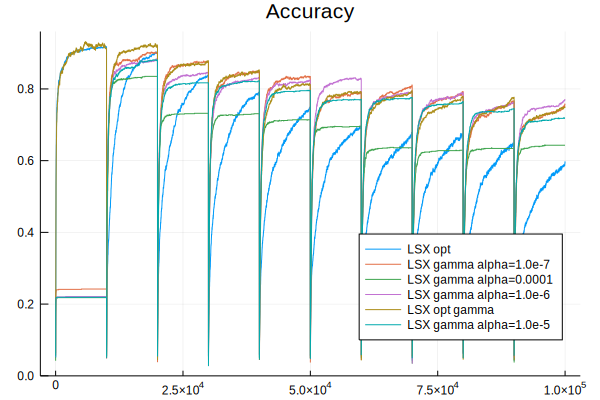

In [23]:
step_axis = [i for i=1:10:size(g1)[1]]
graph = [g1[i, :] for i in step_axis]
graph = hcat(graph...)'
#plot(1:size(g1)[1], g1, label=["RS","RS_tuned"], title="Accuracy")
plot(step_axis, graph, title="Accuracy", label=[key for key in keys(algo_dict)], legend=:bottomright)